## Lineair Regression Model 

We hebben gekozen om een Lineair Regression model eerst toe te passen.De reden hiervoor is dat onze target variabel continu waardes bevatten. Bovendien zijn bevatten de meeste features continu waardes of kunen *encoded* worden naar discrete waardes.

We zullen de volgende feature variabelen in onze Linear Regression model.
* **stm_oorz_groep** : *Aan de hand van deze feature, krijgen we en beter definitie van de bepaalde storing. Welke groep de oorzaak een bepaalde storing geven. *
* **stm_oor_code**   : *Zelfde als hierbove. De soort oorzaak van een bepaalde storing geven*
* **stm_prioriteit** : *De ernst van en bepaalde storing geven.* 

In [1]:
# libraries importeren 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# dataset inlezen 
df = pd.read_csv('data\sap_storing_data_hu_project.csv', low_memory=False)

### Data Understanding

In deze fase gaan we naar de inhoud kijken van de features variabelen en een betere inzicht te krijgen van onze data.

#### Data Collection 

Er wordt een data selectie gedaan. We gaan onze gekozen feature en target variabelen in onze dataset uithalen en in een niewe dataframe zetten. Verder zullen we naar de attributen van de  nieuwe data bekijken.

In [3]:
data = df[['stm_aanntpl_dd','stm_aanntpl_tijd','stm_fh_ddt']].dropna()
data['stm_aanntpl_ddt']  = data['stm_aanntpl_dd']  +" "+ data['stm_aanntpl_tijd']
data['stm_aanntpl_ddt']=pd.to_datetime(data['stm_aanntpl_ddt'])#https://stackoverflow.com/questions/37801321/python-pandas-convert-string-to-time-only
data['stm_fh_ddt']=pd.to_datetime(data['stm_fh_ddt'])
data['reparatietijd']   = data['stm_fh_ddt'] - data['stm_aanntpl_ddt']
#https://stackoverflow.com/questions/17951820/convert-hhmmss-to-minutes-using-python-pandas
data['reparatietijd']= data['reparatietijd'].dt.total_seconds().div(60)

In [4]:
# Data selectie maken van de dataset.
df2  = df[['stm_oorz_groep', 'stm_oorz_code', 'stm_prioriteit']].copy()
df2['reparatietijd'] = data['reparatietijd']
df2.head()

,stm_oorz_groep,stm_oorz_code,stm_prioriteit,reparatietijd
0,NaN,NaN,NaN,NaN
1,ONR-RIB,133.0,9.0,NaN
2,ONR-DERD,143.0,9.0,NaN
3,ONR-DERD,142.0,9.0,NaN
4,ONR-DERD,142.0,9.0,NaN


#### Data Describe 

In dit gedeelte gaan we naar de eigenschappen van onze data bekijken.

In [5]:
# Dimensie van de df2 bekijken
df2.shape

(898526, 4)

In [6]:
# datatypes van de dataset bekijken 
df2.dtypes

stm_oorz_groep     object
stm_oorz_code     float64
stm_prioriteit    float64
reparatietijd     float64
dtype: object

**De meetniveaus van onze feature en target variabelen zijn de volgende:**
* **stm_oorz_groep** : Nominale waardes. Deze kolom moeten we *encoden* naar discrrete waardes
* **stm_oor_code**   : Nominale waardes. Deze kolom moeten we encoden naar discrrete waardes
* **stm_prioriteit** : Continu waardes.
* **reparatietijd**    : Continu waardes.

#### Data Explore

In [7]:
# attributen van df2 bekijken
df2.describe()

,stm_oorz_code,stm_prioriteit,reparatietijd
count,845113.000000,898365.000000,6.839850e+05
mean,193.577248,4.582593,4.972723e+02
std,48.310779,2.262522,2.669839e+04
min,33.000000,1.000000,-5.270005e+05
25%,144.000000,2.000000,1.000000e+01
50%,213.000000,4.000000,3.300000e+01
75%,221.000000,5.000000,8.113333e+01
max,999.000000,9.000000,4.336560e+06


In [8]:
# Aantal ontbrekende waardes bekijken 
df2.isnull().sum()

stm_oorz_groep     53430
stm_oorz_code      53413
stm_prioriteit       161
reparatietijd     214541
dtype: int64

Er is te zien dat we hebben te maken met veel NaN waardes in onze data. <br>
De aantal rijen die we zullen verloren, wordt berekend en weeregeven in percentage.Hierdoor wordt er bepaald of het het verstandig is om al deze NaN waardes te vewijderen.

In [9]:
# bereken aantal rijen die wordt verloren bij Nan waardes
print('Rijen verloren door Nan oorzaakgroep : {}%'.format((df2['stm_oorz_groep'].isnull().sum()/845113)*100))
print('Rijen verloren door Nan oorzaakcode  : {}%'.format((df2['stm_oorz_groep'].isnull().sum()/845113)*100))
print('Rijen verloren door Nan oorzaakcode  : {}%'.format((df2['reparatietijd'].isnull().sum()/845113)*100))
#totaal
print('Totaal aantal rijen verloren : {} %'.format(df2.isnull().sum().sum()/845113*100))

Rijen verloren door Nan oorzaakgroep : 6.322231464904693%
Rijen verloren door Nan oorzaakcode  : 6.322231464904693%
Rijen verloren door Nan oorzaakcode  : 25.38607263170724%
Totaal aantal rijen verloren : 38.047574703027884 %


We verliezen 38% van de data.

We gaan nu  kijken naar elke feature bekijken.

In [10]:
df2['stm_oorz_groep'].unique()

array([nan, 'ONR-RIB', 'ONR-DERD', 'TECHONV', 'WEER'], dtype=object)

In de kolom stm_orz_code gaan we de waarde met de csv bestand Oorzaakcodes verelijken om te zien of er wardes voorkomen die niet gelijk zijn.

In [11]:
df2['stm_oorz_code'][df2['stm_oorz_code'].notnull()].sort_values().unique()

array([ 33.,  48.,  51., 130., 131., 132., 133., 134., 135., 136., 139.,
       140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 154., 180., 181., 182., 183., 184., 185., 186., 187., 188.,
       189., 200., 201., 202., 203., 204., 205., 206., 207., 208., 209.,
       210., 211., 212., 213., 214., 215., 218., 219., 220., 221., 222.,
       223., 224., 225., 226., 227., 228., 229., 230., 231., 233., 234.,
       235., 239., 240., 241., 242., 250., 294., 298., 299., 999.])

In [12]:
oorzcodes = pd.read_csv('data\Oorzaakcodes.csv', delimiter = ';')


We zien dat de waardes 33,  48,51 en 999.
Aan de hand van de bovenstaande code kunnnen we concluderen dat de we moeten df2 filteren die de rijen kiezen, waar de oorzaakcode tussen 130 en 299 zit. We zullen eerst zien hoeveel rijen bevatten deze deze oorzaak codes.

In [13]:
print(len(df2[df2['stm_oorz_code'] == 33]))
print(len(df2[df2['stm_oorz_code'] == 48]))
print(len(df2[df2['stm_oorz_code'] == 51]))
print(len(df2[df2['stm_oorz_code'] == 999]))

1
1
1
102


Er zijn in totaal  105  rijen die deze waardes bevatten.We kunnen dus deze rijen uit onze data verwijderen.

In [14]:
df2['stm_prioriteit'].unique()

array([nan,  9.,  5.,  4.,  2.,  1.,  8.])

Er is geen rij/ storing met een prioriteit van 3 en 6 of 7, maar we  kunnen ze misschien wel  voorspellen anagezien dat ze continu waardes zijn in onze Linear Regression model.

We gaan ook kijken in onze data of er dubbele rijen (storingen voorkomen) dmv duplicated()

In [15]:
df2.columns

Index(['stm_oorz_groep', 'stm_oorz_code', 'stm_prioriteit', 'reparatietijd'], dtype='object')

In [16]:
df2['stm_oorz_groep'].unique()

array([nan, 'ONR-RIB', 'ONR-DERD', 'TECHONV', 'WEER'], dtype=object)

In [17]:
len(df2['stm_oorz_code'].dropna().unique())

76

In [18]:
len(df2['stm_prioriteit'].unique())

7

### Data Preparation 

In deze fase gaan we de data opschonen.

In [19]:
# Alle Nan waardes verwijderen
df2 = df2.dropna()
df2 = df2[(df2['stm_oorz_code'].isin([33, 48,51, 999]))== False] # de rijen verwijderen waar oorzaak groep is gelijk aan 33, 48, 51 en 999

We gaan de feature stm_oorz_groep en oorz_code encoden naar numerieke waardes met behulp van get_dummies().

In [20]:
print(len(df2[df2.duplicated(keep='last')== False])) # kijk naar de dubbele rijen behalve de laatse occurrence. 
df2 = df2[df2.duplicated()== False]

90589


In [21]:
df2.isnull().sum()

stm_oorz_groep    0
stm_oorz_code     0
stm_prioriteit    0
reparatietijd     0
dtype: int64

In [22]:
df2  = pd.get_dummies(df2, columns=["stm_oorz_groep"])

In [23]:
df2  = pd.get_dummies(df2, columns=["stm_oorz_code"])

Als laatst gaan we een data selectie uitvoeren op de df2 waar de reparatietijd tussen 15 minuten en 8 uren zit.

Met behulp van de product owners, weten we dat we maximaal een storing met een reparatietijd van 8 uren moet voorspellen.

Wij kiezen voor een indergrens van 15 minuten. We gaan er  vanuit dat er geen drastische acties worden genomen als de oplossing van een storing korter dan 15minuten duurt.Voor deze storingen gaan wij er vanuit dat de dienstregeling niet aangepast hoeft te worden.

In [24]:
# Data selectie is een range is van 15 en 480.
df2 = df2[(df2['reparatietijd'] >= 15) & (df2['reparatietijd'] <=  480)]

245.5
8219


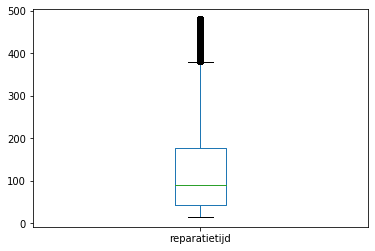

In [25]:
percentile = np.percentile(df2['reparatietijd'].sort_values(), [25,50,75])
Q1 = percentile[0]
Q3 = percentile[2]
IQR =  Q3 - Q1

gns = Q1+1.5*IQR
print(gns)
print(len(df2[df2['reparatietijd']>gns])) 
df2['reparatietijd'].plot.box()

In [26]:
#attributen bekijken
df2.describe()

,stm_prioriteit,reparatietijd,stm_oorz_groep_ONR-DERD,stm_oorz_groep_ONR-RIB,stm_oorz_groep_TECHONV,stm_oorz_groep_WEER,stm_oorz_code_130.0,stm_oorz_code_131.0,stm_oorz_code_132.0,stm_oorz_code_133.0,...,stm_oorz_code_234.0,stm_oorz_code_235.0,stm_oorz_code_239.0,stm_oorz_code_240.0,stm_oorz_code_241.0,stm_oorz_code_242.0,stm_oorz_code_250.0,stm_oorz_code_294.0,stm_oorz_code_298.0,stm_oorz_code_299.0
count,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000,...,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000,57397.000000
mean,3.808649,125.537150,0.209384,0.085126,0.620921,0.084569,0.000679,0.000958,0.007805,0.037127,...,0.003432,0.001882,0.001028,0.007614,0.012213,0.005506,0.003746,0.042354,0.012806,0.007021
std,1.510927,106.386097,0.406872,0.279072,0.485162,0.278242,0.026058,0.030941,0.088003,0.189076,...,0.058485,0.043337,0.032045,0.086924,0.109837,0.073995,0.061089,0.201398,0.112436,0.083499
min,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,89.700000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,178.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,480.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
# Opgeschone data opslaan in een pickle bestand
df2.to_pickle("data.pkl")

## Nieuw Baseline Model 

Er zal een nieuwe baseline model opesteld worden op base van de opgeschone data en de data selectie die we hadden gedaan.

In [28]:
#Nieuwe baseline model maken op bas evan de opgeschone data.
# kopie van de data voor zekerheid
df2_baseline = df2.copy()

In [29]:
# Baselinne model    maken 
def baselinemodel(data,kolom):
    data['Median']=  data[kolom].median()
    # De kwaliteit/score van de model bepalen mbh van RMSE
    score =np.sqrt(mse(data.loc[:,kolom],data.loc[:,'Median']))
    return score

In [30]:
basescore = baselinemodel(df2_baseline, 'reparatietijd')
basescore

112.25910075267038

In [31]:
df2.to_pickle('df2.pkl')

## Linear regression model 

In [37]:
def linearRegression(features, target):
    x_train, x_test, y_train, y_test = train_test_split(features, target) # splitsen in traiining en testing dataset
    # Geeft de dimensie van de opgesplitste datasets
    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    linreg = LinearRegression()
    #fit model 
    linreg.fit(x_train, y_train)
    # Make prediction
    y_pred = linreg.predict(x_test)
    #Evaluate mbh van RMSE
    lrscore = np.sqrt(mse(y_test, y_pred))
    return lrscore

In [38]:
#df2

In [39]:
#Data opsplitsen in features en target variabelen.
features = df2.drop('reparatietijd', axis = 1)
target = df2['reparatietijd']

In [40]:
lrscore = linearRegression(features, target)
lrscore

(43047, 76)
(43047,)
(14350, 76)
(14350,)


105.24350509442253

In [41]:
# Bereken de afwijking met de baseline model  in percentage
((basescore - lrscore )/ basescore)*100 

6.249467180130572

##### Conclusie:
De score van onze Linear Regressie model is lager dan de score van de baseline model. <br>
Er is een verbetering van relatief 7,7 %. Dit is best een groot verschil , dus we kunnen zeggen dat deze model  een redelijke model om   toe te paseen.